In [1]:
import torch
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from main import nvi_declarative, test, plot_sample_hist, mk_model
from combinators.utils import load_models, models_as_dict
from experiments.annealing.objectives import nvo_avo, nvo_rkl
%matplotlib inline

directory = "./sync/weights/"


In [2]:
sample_shape = (50000, 10)
# ==================================== #

nvirs_model = mk_model(8, optimize_path=True)
load_models(models_as_dict(
    nvirs_model,
    ["targets", "forwards", "reverses"]),
    filename="nvirs_nvo_rkl_S288_K8_I20000_seed0.pt",
    weights_dir=directory)
nvirs = nvi_declarative(*nvirs_model, loss_fn=nvo_rkl, resample=False)
_,_,_, samples_nvirs, _ = test(nvirs, sample_shape, batch_dim=1, sample_dims=0)

# ==================================== #
_, samples_nvirs_last = samples_nvirs[-1]

/nix/store/1fw9h2capcs2dpc7pgc39pn3g0zwm078-python3-3.8.6-env/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
torch.sigmoid(nvirs_model[0][1].logit)

tensor(1.4024e-05, grad_fn=<SigmoidBackward>)

In [4]:
g0_out = nvirs_model[0][0](None, batch_dim=1, sample_dims=0, sample_shape=sample_shape)
samples_g0 = g0_out.output['g0']
_, samples_baseline = nvirs_model[0][-1].sample(sample_shape=sample_shape)
samples_baseline.shape

torch.Size([500000, 2])

findfont: Font family ['Inconsolata'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Inconsolata'] not found. Falling back to DejaVu Sans.


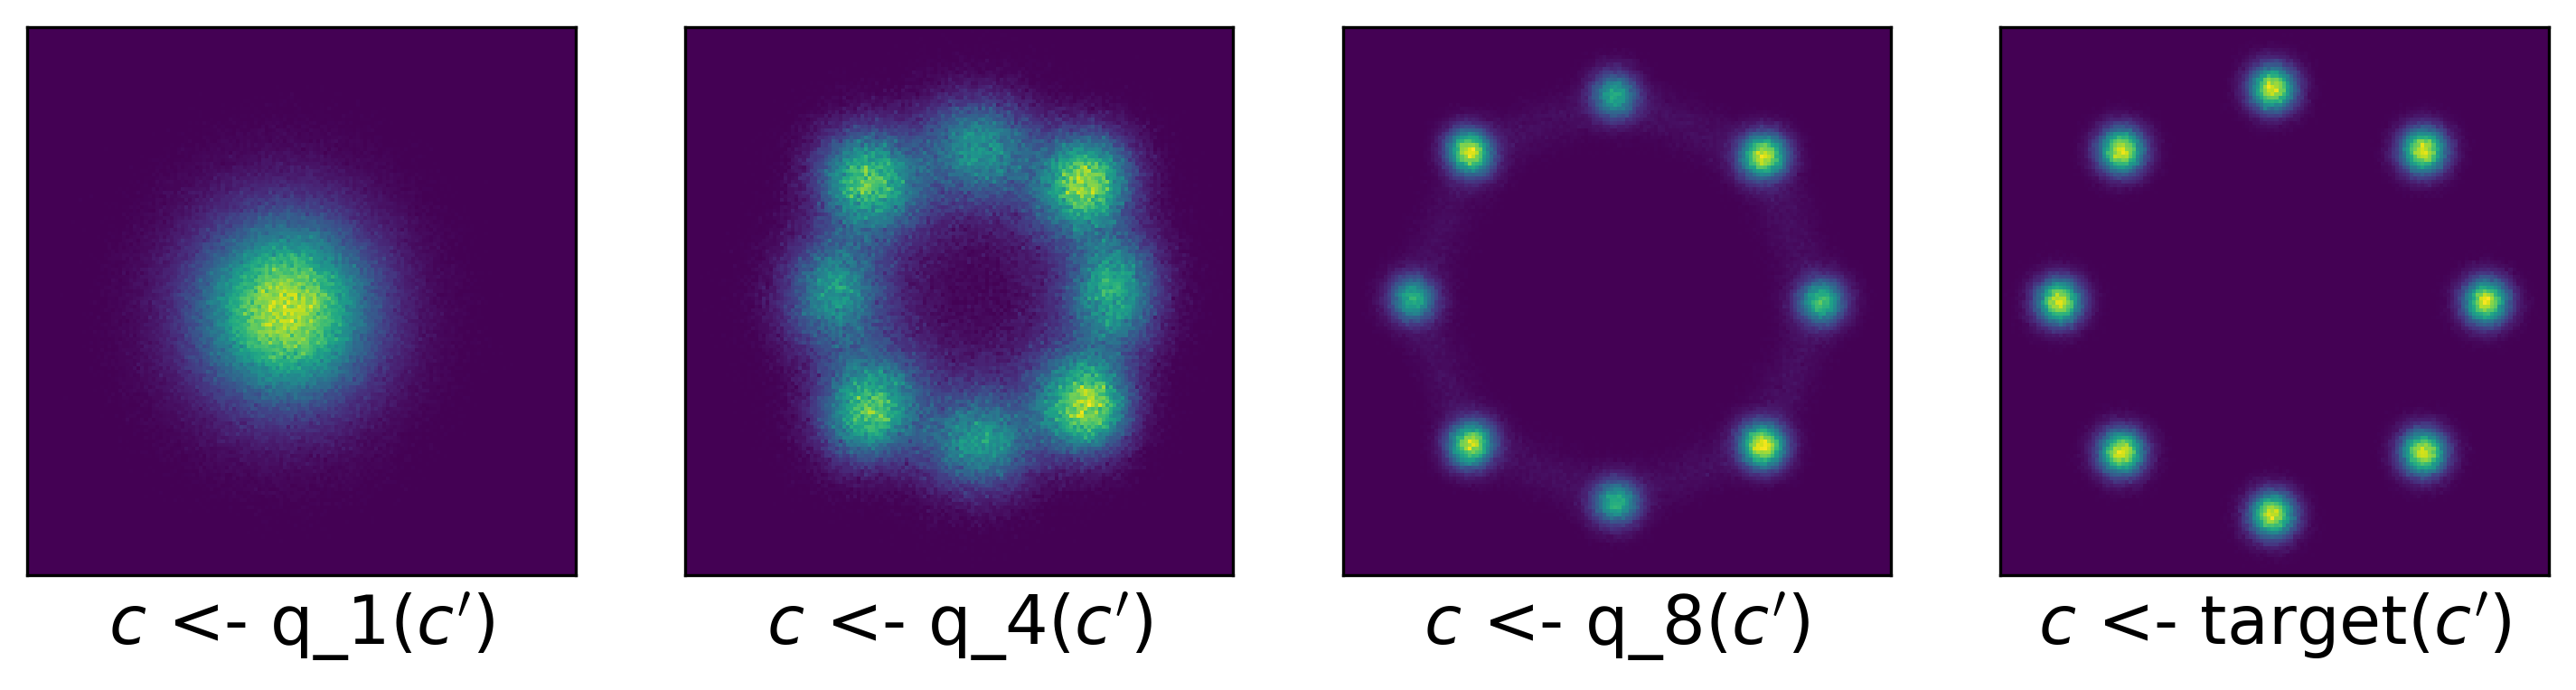

In [5]:
filename = 'annealing-extra.svg'
K=3

if not os.path.exists("./figures/"):
    os.makedirs("./figures/")

select = lambda i: ("$c$ <- q_{}($c'$)".format(i+2), samples_nvirs[i][1])
selected_samples = [("$c$ <- q_1($c'$)", samples_g0),
                    #select(0),
                    select(2),
                    select(6)
                    ]
# selected_samples = samples_nvirs
K = len(selected_samples) + 1 # for baseline

fig = plt.figure(figsize=(3*K, 3*1), dpi=300)
for k in range(K-1):
    ax = fig.add_subplot(1, K, k+1)
    ax.tick_params(bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    label, X = selected_samples[k]
    ax.set_xlabel(label, fontsize=18)

    plot_sample_hist(ax, X, bins=150)

ax_last = fig.add_subplot(1, K, K)
ax_last.tick_params(bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
X = samples_baseline.squeeze()
plot_sample_hist(ax_last, X, bins=150)
ax_last.set_xlabel("$c$ <- target($c'$)", fontsize=18, fontname="Inconsolata")
hfont = {'fontname':'Helvetica'}


fig.savefig("figures/{}".format(filename), bbox_inches='tight')